Index(['NCT Number', 'Study Title', 'Brief Summary', 'Interventions',
       'Adjuvant Name_x', 'Adjuvant Name_y'],
      dtype='object')
Index(['NCT Number', 'Study Title', 'Brief Summary', 'Interventions',
       'Adjuvant Name_x', 'Adjuvant Name_y'],
      dtype='object')
Index(['NCT Number', 'Study Title', 'Brief Summary', 'Interventions',
       'Adjuvant Name_x', 'Adjuvant Name_y'],
      dtype='object')
Index(['NCT Number', 'Study Title', 'Brief Summary', 'Interventions',
       'Adjuvant Name_x', 'Adjuvant Name_y'],
      dtype='object')
Index(['NCT Number', 'Study Title', 'Brief Summary', 'Interventions',
       'Adjuvant Name_x', 'Adjuvant Name_y'],
      dtype='object')
Index(['NCT Number', 'Study Title', 'Brief Summary', 'Interventions',
       'Adjuvant Name_x', 'Adjuvant Name_y'],
      dtype='object')
Index(['NCT Number', 'Study Title', 'Brief Summary', 'Interventions',
       'Adjuvant Name_x', 'Adjuvant Name_y'],
      dtype='object')
Index(['NCT Number', 'Study Title'

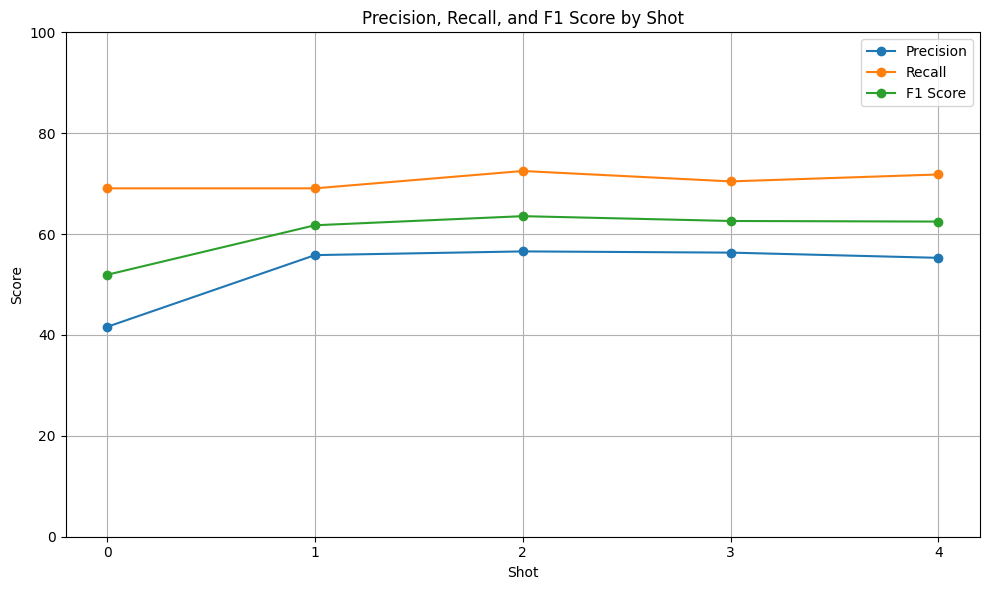

In [1]:
import pandas as pd
import os

# Abbreviation dictionary
abbreviation_dict = {
    "IFA": "Incomplete Freund's Adjuvant",
    "Incomplete Freund's adjuvant (IFA)": "Incomplete Freund's Adjuvant",
    "rhGM-CSF": "GM-CSF",
    "Sargramostim (GM-CSF)": "GM-CSF",
    "recombinant fowlpox GM-CSF vaccine adjuvant": "GM-CSF",
    "granulocyte-macrophage colony-stimulating factor (GM-CSF)": "GM-CSF",
    "Montanide ISA 51 VG": "Montanide ISA 51",
    "Montanide ISA-51 VG": "Montanide ISA 51",
    "MONTANIDE ISA 51 VG": "Montanide ISA 51",
    "Montanide ISA51 VG": "Montanide ISA51",
    "Interleukin-2": "IL-2",
    "polyinosinic-polycytidylic acid - poly-L-lysine carboxymethylcellulose (poly-ICLC)": "Poly-ICLC",
    "Hiltonol (Poly-ICLC)": "Poly-ICLC",
    "gp96 heat shock protein-peptide complex": "GP96",
    "Therapeutic Vaccine GI-4000": "GI-4000"
}

# Normalization Functions
def resolve_abbreviation(name):
    return abbreviation_dict.get(name.strip(), name.strip())

def normalize_token(token):
    token = resolve_abbreviation(token)
    token = token.lower().strip()
    token = token.replace("drug: ", "").replace("biological: ", "")
    token = token.replace("-", " ").replace("  ", " ")
    token = token.replace(" adjuvant vaccine", "").replace(" adjuvant system", "").replace(" adjuvant", "")
    token = token.replace(" ", "")
    return token

def smart_tokenize(adjuvant_str):
    if pd.isna(adjuvant_str):
        return set()
    tokens = [t.strip() for t in adjuvant_str.split(",") if t.strip()]
    return set(normalize_token(t) for t in tokens)

def evaluate_row_smart(row):
    x_tokens = smart_tokenize(row['Adjuvant Name_x'])
    y_tokens = smart_tokenize(row['Adjuvant Name_y'])
    tp = len(x_tokens & y_tokens)
    fp = len(y_tokens - x_tokens)
    fn = len(x_tokens - y_tokens)
    tn = 1 if not x_tokens and not y_tokens else 0
    return pd.Series([tp, fp, fn, tn], index=['TP', 'FP', 'FN', 'TN'])

# Main Evaluation Loop

import pandas as pd
import os

# Store all results
results = []
output_dir = "shot_run_analysis_outputs/google-gemma-2-9b-it_llama_prompt2_with_Interventions/"

os.makedirs(output_dir, exist_ok=True)

# Loop through each shot and run
for shot in range(0, 5):  # 0 to 4 shot
    for run in range(1, 4):  # Run1 to Run3
        try:
            base_path = f"google-gemma-2-9b-it_llama_prompt2_with_Interventions_{shot}shot"
            file_name = f"AdjuvareDB104_T0.0001_Run{run}_Merged_with_GoldStandard.csv"
            full_path = os.path.join(base_path, "Single_Trial_with_Interventions_Only_AdjuvareDB104_T0.0001_16December", file_name)

            # Load CSV and select columns
            df = pd.read_csv(full_path)
            print(df.columns)
            selected_columns = ['NCT Number', 'Adjuvant Name_x', 'Adjuvant Name_y']
            df_selected = df[selected_columns].copy()

            # Group and clean
            grouped_df = df_selected.groupby('NCT Number').agg({
                'Adjuvant Name_x': lambda x: ', '.join(sorted(set(x.dropna()))),
                'Adjuvant Name_y': lambda x: ', '.join(sorted(set(x.dropna())))
            }).reset_index()

            # Clean 'and' to ','
            grouped_df['Adjuvant Name_x'] = grouped_df['Adjuvant Name_x'].str.replace(r'\s*and\s*', ', ', regex=True)
            grouped_df['Adjuvant Name_y'] = grouped_df['Adjuvant Name_y'].str.replace(r'\s*and\s*', ', ', regex=True)

            # Evaluate smart match
            grouped_df[['TP', 'FP', 'FN', 'TN']] = grouped_df.apply(evaluate_row_smart, axis=1)

            # Calculate totals
            TP = grouped_df['TP'].sum()
            FP = grouped_df['FP'].sum()
            FN = grouped_df['FN'].sum()
            precision = 100*TP / (TP + FP) if (TP + FP) else 0
            recall = 100*TP / (TP + FN) if (TP + FN) else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0

            # Store result summary
            results.append({
                'Shot': shot,
                'Run': run,
                'TP': TP,
                'FP': FP,
                'FN': FN,
                'Precision': round(precision, 4),
                'Recall': round(recall, 4),
                'F1': round(f1, 4)
            })

            # Save individual grouped DataFrame
            output_csv = os.path.join(output_dir, f"grouped_shot{shot}_run{run}.csv")
            grouped_df.to_csv(output_csv, index=False)

        except Exception as e:
            print(f"Error processing shot={shot}, run={run}: {e}")

# Results Summary
results_df = pd.DataFrame(results)

# Save full results
results_df.to_csv(os.path.join(output_dir, "results_by_shot_and_run.csv"), index=False)

# Average metrics per Shot across all runs
avg_by_shot = results_df.groupby('Shot').agg({
    'TP': 'mean',
    'FP': 'mean',
    'FN': 'mean',
    'Precision': 'mean',
    'Recall': 'mean',
    'F1': 'mean'
}).reset_index()

# Round for display
avg_by_shot[['Precision', 'Recall', 'F1']] = avg_by_shot[['Precision', 'Recall', 'F1']].round(4)

# Save average by shot
avg_by_shot.to_csv(os.path.join(output_dir, "average_by_shot.csv"), index=False)

# Plot Precision, Recall, F1 Score vs. Shot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(avg_by_shot['Shot'], avg_by_shot['Precision'], marker='o', label='Precision')
plt.plot(avg_by_shot['Shot'], avg_by_shot['Recall'], marker='o', label='Recall')
plt.plot(avg_by_shot['Shot'], avg_by_shot['F1'], marker='o', label='F1 Score')

plt.xlabel('Shot')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score by Shot')
plt.xticks(avg_by_shot['Shot'])
plt.ylim(0, 100)
plt.grid(True)
plt.legend()
plt.tight_layout()

# Save plot image
plot_path = os.path.join(output_dir, "precision_recall_f1_by_shot.svg")
plt.savefig(plot_path)
plt.show()

In [2]:
'google-gemma-2-9b-it_llama_prompt2_without_Interventions_0shot/Single_Trial_without_Interventions_Only_AdjuvareDB104_T0.0001_16December/AdjuvareDB104_T0.0001_Run1_Merged_with_GoldStandard.csv'

'google-gemma-2-9b-it_llama_prompt2_without_Interventions_0shot/Single_Trial_without_Interventions_Only_AdjuvareDB104_T0.0001_16December/AdjuvareDB104_T0.0001_Run1_Merged_with_GoldStandard.csv'